# Exercise - Exploratory Data Analysis (EDA)
- helps you understand dataset
- detect potential issues
- and refine preprocessing steps

## Workshop Sample Dataset
- https://storage.googleapis.com/nmfs_odp_pifsc/PIFSC/ESD/ARP/pifsc-ai-data-repository/fish-detection/workshop/fish_dataset.zip

In [1]:
# 📌 Step 1: Install Required Libraries (If Not Installed)
!pip install opencv-python numpy pandas matplotlib tqdm albumentations

In [2]:
# 📌 Step 2: Import Necessary Libraries
import os
import requests
import zipfile
from tqdm import tqdm
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from collections import Counter

In [3]:
# 📌 Step 3: Define Dataset URL and Paths
dataset_url = "https://storage.googleapis.com/nmfs_odp_pifsc/PIFSC/ESD/ARP/pifsc-ai-data-repository/fish-detection/workshop/fish_dataset.zip"

dataset_zip_path = "/content/fish_dataset.zip"
dataset_extract_path = "/content/fish_dataset/"


## Download Dataset

In [4]:
# 📌 Step 4: Download the Dataset from Google Cloud Storage
def download_file(url, output_path):
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get("content-length", 0))

    with open(output_path, "wb") as file, tqdm(
        desc="Downloading Dataset",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            file.write(data)
            bar.update(len(data))

# Download only if it doesn't exist
if not os.path.exists(dataset_zip_path):
    download_file(dataset_url, dataset_zip_path)
else:
    print("✔ Dataset already downloaded.")


## Extract Dataset

In [5]:
# 📌 Step 5: Extract the Dataset
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"✔ Extracted dataset to {extract_to}")

# Extract only if the folder does not exist
if not os.path.exists(dataset_extract_path):
    extract_zip(dataset_zip_path, dataset_extract_path)
else:
    print("✔ Dataset already extracted.")


✔ Extracted dataset to /content/fish_dataset/



## A YOLO Object Detection Dataset should be in 1 of 2 folder structures
```
fish_dataset/
  ├── train/
  │   ├── images/
  │   ├── labels/
  ├── val/
  │   ├── images/
  │   ├── labels/
  ```
OR
  ```
  fish_dataset/
  ├── images/
  │   ├── train/
  │   ├── val/
  │   ├── test/
  ├── labels/
  │   ├── train/
  │   ├── val/
  │   ├── test/

  ```

In [6]:
# 📌 Print dataset.yaml content
yaml_path = "/content/fish_dataset/dataset.yaml"

if os.path.exists(yaml_path):
    with open(yaml_path, "r") as file:
        print(file.read())
else:
    print("❌ dataset.yaml not found!")


train: images/train
val: images/val

# Number of classes
nc: 1

# Class names
names: ['fish']



In [7]:
# 📌 Step 6: Verify Dataset Structure
for split in ["train", "val", "test"]:
    img_path = os.path.join(dataset_extract_path, "images", split)
    lbl_path = os.path.join(dataset_extract_path, "labels", split)

    # Ensure folders exist before counting files
    img_count = len(os.listdir(img_path)) if os.path.exists(img_path) else 0
    lbl_count = len(os.listdir(lbl_path)) if os.path.exists(lbl_path) else 0

    print(f"✔ {split.upper()} - Images: {img_count}, Labels: {lbl_count}")


✔ TRAIN - Images: 786, Labels: 786
✔ VAL - Images: 196, Labels: 196
✔ TEST - Images: 0, Labels: 0


In [9]:
# 📌 Step 7: Run Exploratory Data Analysis (EDA)
dataset_root = dataset_extract_path  # Set dataset path

# Define paths for train and validation sets
train_img_dir = os.path.join(dataset_root, "images", "train")
train_lbl_dir = os.path.join(dataset_root, "labels", "train")
val_img_dir = os.path.join(dataset_root, "images", "val")
val_lbl_dir = os.path.join(dataset_root, "labels", "val")

# Load train and validation image/label paths
train_image_paths = sorted(glob(os.path.join(train_img_dir, "*.jpg")))
train_label_paths = sorted(glob(os.path.join(train_lbl_dir, "*.txt")))

val_image_paths = sorted(glob(os.path.join(val_img_dir, "*.jpg")))
val_label_paths = sorted(glob(os.path.join(val_lbl_dir, "*.txt")))

# Print dataset statistics
print(f"📊 Total Training Images: {len(train_image_paths)}, Total Training Labels: {len(train_label_paths)}")
print(f"📊 Total Validation Images: {len(val_image_paths)}, Total Validation Labels: {len(val_label_paths)}")

📊 Total Training Images: 786, Total Training Labels: 786
📊 Total Validation Images: 196, Total Validation Labels: 196


In [10]:
# 📌 Step 9: Class Distribution Analysis
class_counts = Counter()
for label_path in label_paths:
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id = line.strip().split()[0]
            class_counts[class_id] += 1

df_class_distribution = pd.DataFrame(class_counts.items(), columns=["Class_ID", "Count"])
df_class_distribution.sort_values(by="Count", ascending=False, inplace=True)
df_class_distribution


,Class_ID,Count
0,0,457


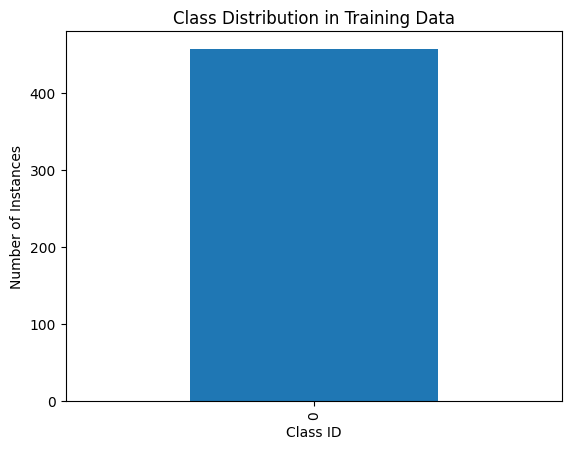

In [11]:
# 📌 Step 10: Plot Class Distribution
df_class_distribution.plot(kind="bar", x="Class_ID", y="Count", legend=False)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class ID")
plt.ylabel("Number of Instances")
plt.show()


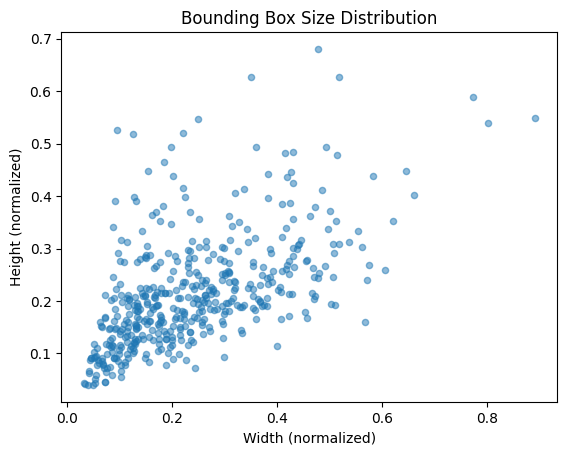

In [17]:
# 📌 Step 11: Bounding Box Size Distribution
bbox_sizes = []
for label_path in label_paths:
    with open(label_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            _, _, _, width, height = map(float, line.strip().split())
            bbox_sizes.append((width, height))

df_bbox = pd.DataFrame(bbox_sizes, columns=["Width", "Height"])

# Scatter plot of bounding box sizes
df_bbox.plot(kind="scatter", x="Width", y="Height", alpha=0.5)
plt.title("Bounding Box Size Distribution")
plt.xlabel("Width (normalized)")
plt.ylabel("Height (normalized)")
plt.show()


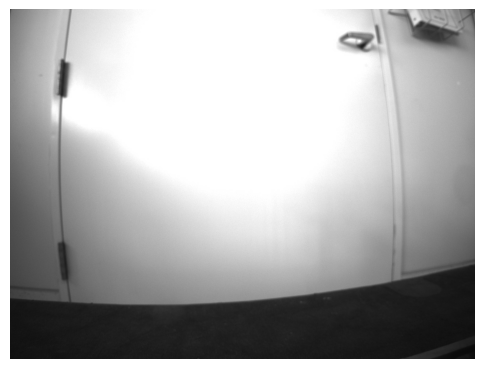

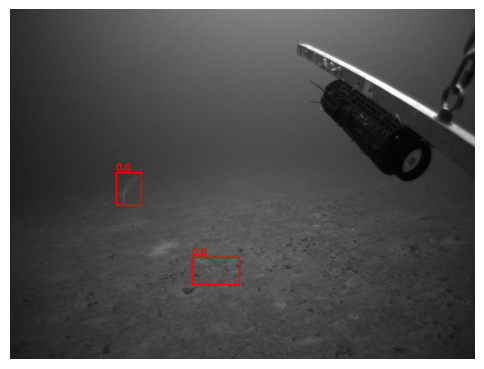

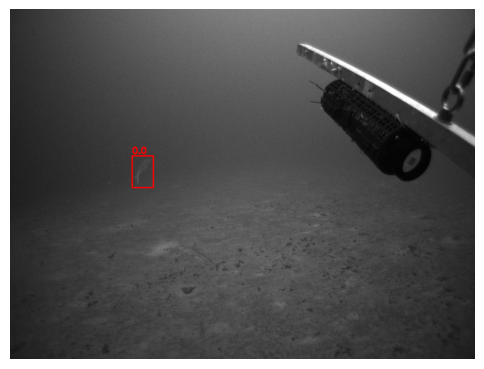

In [19]:
# 📌 Step 12: Visualizing Annotations on Images
def plot_sample_image(img_path, label_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        class_id, x, y, box_w, box_h = map(float, line.strip().split())
        x1 = int((x - box_w / 2) * w)
        y1 = int((y - box_h / 2) * h)
        x2 = int((x + box_w / 2) * w)
        y2 = int((y + box_h / 2) * h)

        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, str(class_id), (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Test on a few images
for i in range(3):
    plot_sample_image(image_paths[i], label_paths[i])


In [20]:
# 📌 Step 13: Check for Corrupt Images
corrupt_images = []

for img_path in image_paths:
    try:
        img = cv2.imread(img_path)
        if img is None:
            corrupt_images.append(img_path)
    except Exception as e:
        corrupt_images.append(img_path)

print(f"❌ Found {len(corrupt_images)} corrupt images.")

# Remove corrupt images
for img_path in corrupt_images:
    os.remove(img_path)
    print(f"🗑️ Removed: {img_path}")


❌ Found 0 corrupt images.


In [12]:
# 📌 Step 14: Check for Empty Label Files in Training Set
empty_labels = []

train_label_paths = sorted(glob(os.path.join(dataset_extract_path, "labels", "train", "*.txt")))

for label_path in train_label_paths:
    if os.stat(label_path).st_size == 0:  # If label file is empty
        empty_labels.append(label_path)

print(f"❌ Found {len(empty_labels)} empty label files in TRAIN set.")

# Remove empty label files ONLY from the training set
for label_path in empty_labels:
    os.remove(label_path)
    print(f"🗑️ Removed empty train label file: {label_path}")


❌ Found 77 empty label files in TRAIN set.
🗑️ Removed empty train label file: /content/fish_dataset/labels/train/00019.txt
🗑️ Removed empty train label file: /content/fish_dataset/labels/train/00143.txt
🗑️ Removed empty train label file: /content/fish_dataset/labels/train/01131.txt
🗑️ Removed empty train label file: /content/fish_dataset/labels/train/20161014.192648.087.003747.txt
🗑️ Removed empty train label file: /content/fish_dataset/labels/train/20161014.192757.391.004579.txt
🗑️ Removed empty train label file: /content/fish_dataset/labels/train/20161014.192813.051.004767.txt
🗑️ Removed empty train label file: /content/fish_dataset/labels/train/20161014.192813.468.004772.txt
🗑️ Removed empty train label file: /content/fish_dataset/labels/train/20161014.192819.718.004847.txt
🗑️ Removed empty train label file: /content/fish_dataset/labels/train/20161014.193227.870.007826.txt
🗑️ Removed empty train label file: /content/fish_dataset/labels/train/20161014.193715.346.011277.txt
🗑️ Removed

In [13]:
# 📌 Step 17: Check for Duplicate Images Across Splits
train_images = set(glob(os.path.join(dataset_extract_path, "images", "train", "*.jpg")))
val_images = set(glob(os.path.join(dataset_extract_path, "images", "val", "*.jpg")))
test_images = set(glob(os.path.join(dataset_extract_path, "images", "test", "*.jpg")))

duplicates_train_val = train_images.intersection(val_images)
duplicates_train_test = train_images.intersection(test_images)
duplicates_val_test = val_images.intersection(test_images)

print(f"⚠️ {len(duplicates_train_val)} duplicates found between Train and Val.")
print(f"⚠️ {len(duplicates_train_test)} duplicates found between Train and Test.")
print(f"⚠️ {len(duplicates_val_test)} duplicates found between Val and Test.")


⚠️ 0 duplicates found between Train and Val.
⚠️ 0 duplicates found between Train and Test.
⚠️ 0 duplicates found between Val and Test.
